In [1]:
# optical_model.py  ---------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import physical_constants, pi
import mpmath as mp

mp.dps = 70                                            # extra precision

ħc  = 197.3269804                                      # MeV·fm
α   = 1 / 137.035999084
e2_4pie0 = α * ħc                                      # MeV·fm
m_u = physical_constants['atomic mass constant energy equivalent in MeV'][0]

# --------------------- ENDF/B-VI points (lab, MeV & barn) ---------------- #
_E_lab_ENDF = np.array([
      200,   300,   400,    700,    1000,   4000,   7000,  10000,  14000,
     20000, 26000, 35000,  40000,   65000,  80000,  95000, 104000, 110000,
    120000,135000,150000, 180000,  220000, 280000], dtype=float) * 1e-6  # MeV
_sigma_ENDF = np.array([
 7.433e-39, 4.056e-31, 1.586e-26, 2.514e-19, 1.000e-15,
 1.160e-06, 1.544e-04, 1.730e-03, 1.092e-02, 5.968e-02,
 1.691e-01, 4.700e-01, 1.370e+00, 2.656e+00, 3.957e+00,
 4.801e+00, 4.980e+00, 5.010e+00, 4.877e+00, 4.465e+00,
 3.970e+00, 3.072e+00, 2.203e+00, 1.505e+00], dtype=float)

# --------------------------- helpers ------------------------------------ #
def _reduced_mass(Ap, At):
    return Ap * m_u * At / (Ap + At)

def _coulomb_FG(l, η, ρ):
    F  = mp.coulombf(l, η, ρ)
    G  = mp.coulombg(l, η, ρ)
    Fp = mp.diff(lambda x: mp.coulombf(l, η, x), ρ)
    Gp = mp.diff(lambda x: mp.coulombg(l, η, x), ρ)
    return complex(F), complex(G), complex(Fp), complex(Gp)

def _delta0(E, Zp, Zt, Ap, At, Vr, Vi, r0):
    mr = _reduced_mass(Ap, At)
    k  = np.sqrt(2*mr*E) / ħc
    ac = ħc**2 / (mr * e2_4pie0 * Zp * Zt)
    η  = 1 / (k * ac)
    RN = r0 * (At**(1/3) + Ap**(1/3))
    kN = np.sqrt(2*mr*(E - Vr - 1j*Vi)) / ħc
    ρ  = k * RN

    F, G, Fp, Gp = _coulomb_FG(0, η, ρ)
    cot_kN_RN = np.cos(kN*RN) / np.sin(kN*RN)
    W = (kN*cot_kN_RN*G - k*Gp) / (k*Fp - kN*cot_kN_RN*F)
    δ = np.arctan(1 / W)
    return δ, W, k, ac

def _sigma_S(E, k, W, mr, Zp, Zt):
    Wr, Wi = W.real, W.imag
    sigma = pi / k**2 * (-4 * Wi) / (Wr**2 + (Wi - 1)**2)      # barn
    BG = Zp * Zt * e2_4pie0 * np.sqrt(2*mr) / ħc               # MeV^½·fm

    # Use mpmath to avoid overflow in exp(BG/√E)
    E_mpf = mp.mpf(E)
    try:
        S_mpf = mp.mpf(sigma) * E_mpf * mp.e**(BG / mp.sqrt(E_mpf))
        S = float(S_mpf) if mp.log(S_mpf) < 700 else np.nan     # clip >1e304
    except (OverflowError, ValueError):
        S = np.nan
    return sigma, S

def _wavefunction(r, E, p):
    Zp, Zt, Ap, At, Vr, Vi, r0 = p
    mr = _reduced_mass(Ap, At)
    k  = np.sqrt(2*mr*E) / ħc
    RN = r0 * (At**(1/3) + Ap**(1/3))
    δ, _, k_val, ac = _delta0(E, *p[:4], Vr, Vi, r0)
    kN = np.sqrt(2*mr*(E - Vr - 1j*Vi)) / ħc

    B  = 1.0
    F0, G0, Fp0, Gp0 = _coulomb_FG(0, 1/(k_val*ac), k_val*RN)
    cotδ = 1 / np.tan(δ)
    D = B * np.sin(kN*RN) / (F0*cotδ + G0)

    u  = np.where(r<RN, B*np.sin(kN*r), D*(F0*cotδ + G0))
    du = np.where(r<RN, B*kN*np.cos(kN*r), D*(Fp0*cotδ + Gp0)*k_val)
    return u, du

# --------------------------- main callable ------------------------------ #
def run_optical_model(
        Zp:int, Zt:int, Ap:float, At:float,
        Vr:float, Vi:float, r0:float,
        Ecm_range_eV=(120.0, 168000.0), n_E=600,
        E_demo_cm_eV=None,
        show=True, return_data=False):
    """
    Optical-model calculation and plots.

    Parameters
    ----------
    Zp, Zt, Ap, At, Vr, Vi, r0 : usual optical-model parameters.
    Ecm_range_eV : (min,max) tuple in **eV** (default 120–168 000 eV).
    n_E          : number of energy points.
    E_demo_cm_eV : centre-of-mass energy (eV) for which to plot u0(r);
                   set None to skip the radial plot.
    show         : if True, display the figures.
    return_data  : if True, return dict with arrays.

    Returns
    -------
    None or dict
    """
    # convert to MeV
    Emin_MeV, Emax_MeV = [x*1e-6 for x in Ecm_range_eV]
    Ecm = np.geomspace(Emin_MeV, Emax_MeV, n_E)      # log spacing better here
    Elab = (Ap + At)/At * Ecm

    params = (Zp, Zt, Ap, At, Vr, Vi, r0)
    mr = _reduced_mass(Ap, At)

    δ, σ, S = [], [], []
    for E in Ecm:
        δE, WE, kE, _ = _delta0(E, *params)
        σE, SE = _sigma_S(E, kE, WE, mr, Zp, Zt)
        δ.append(δE); σ.append(σE); S.append(SE)

    δ = np.array(δ); σ = np.array(σ); S = np.array(S)

    # ------------- plots -------------
    if show:
        fig, ax = plt.subplots(2, 2, figsize=(10,8))
        ax[0,0].plot(Ecm*1e6, np.degrees(δ.real))
        ax[0,0].set_xlabel("E_cm (eV)"); ax[0,0].set_xscale('log')
        ax[0,0].set_ylabel("Re δ0 (deg)")

        ax[0,1].plot(Ecm*1e6, np.degrees(δ.imag))
        ax[0,1].set_xlabel("E_cm (eV)"); ax[0,1].set_xscale('log')
        ax[0,1].set_ylabel("Im δ0 (deg)")

        ax[1,0].plot(Elab, σ, label="Optical-model")
        ax[1,0].scatter(_E_lab_ENDF, _sigma_ENDF, s=30,
                        color='red', label="ENDF/B-VI")
        ax[1,0].set_xlabel("E_lab (MeV)"); ax[1,0].set_ylabel("σ (barn)")
        ax[1,0].set_xscale('log'); ax[1,0].set_yscale('log'); ax[1,0].legend()

        ax[1,1].plot(Elab, S)
        ax[1,1].set_xlabel("E_lab (MeV)"); ax[1,1].set_ylabel("S (MeV·barn)")
        ax[1,1].set_xscale('log'); ax[1,1].set_yscale('log')

        fig.tight_layout(); plt.show()

        # ----- optional radial plot -----
        if E_demo_cm_eV is not None:
            E_demo = E_demo_cm_eV*1e-6
            ac = ħc**2 / (mr * e2_4pie0 * Zp * Zt)
            r = np.linspace(1e-4, 2*ac, 3000)
            u, du = _wavefunction(r, E_demo, params)

            plt.figure(figsize=(7,4))
            plt.plot(r, u.real, label='Re u0')
            plt.plot(r, u.imag, ls='--', label='Im u0')
            plt.xlabel("r (fm)"); plt.ylabel("u0"); plt.legend(); plt.tight_layout()
            plt.show()

            plt.figure(figsize=(7,4))
            plt.plot(r, du.real, label='Re du0/dr')
            plt.plot(r, du.imag, ls='--', label='Im du0/dr')
            plt.xlabel("r (fm)"); plt.ylabel("du0/dr"); plt.legend(); plt.tight_layout()
            plt.show()

    if return_data:
        return dict(Ecm_eV=Ecm*1e6, Elab_MeV=Elab, delta=δ, sigma=σ, S=S)

# ---------------- sample call (comment/remove in production) -------------
# run_optical_model(1,2,2,3, Vr=10.0, Vi=5.0, r0=1.2,
#                   E_demo_cm_eV=5e4)     # 50 keV example


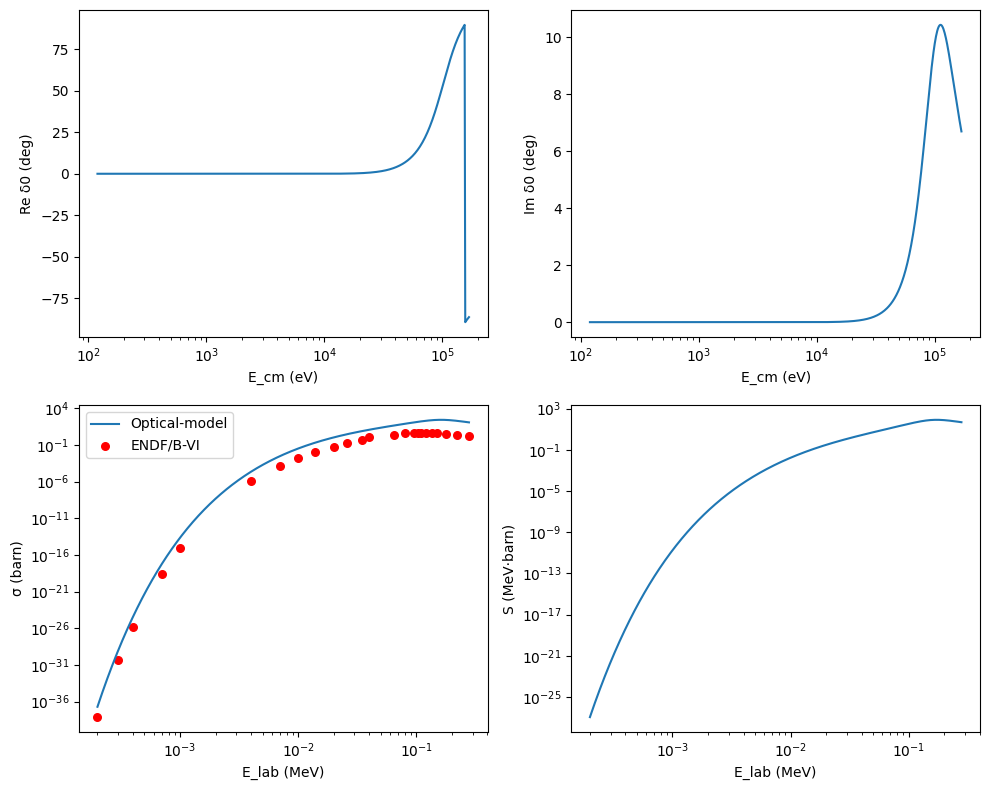

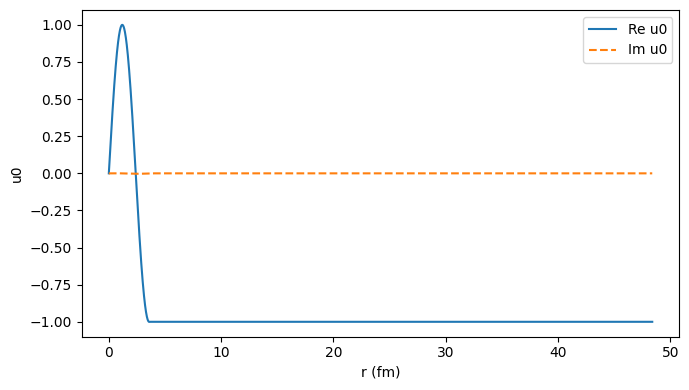

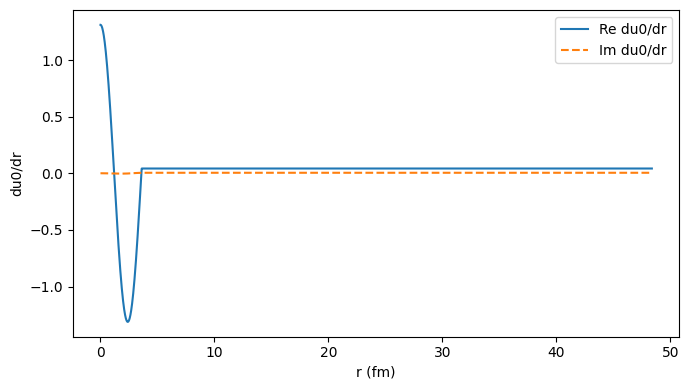

In [2]:
run_optical_model(
    Zp=1, Zt=1,        # deuterón + algo
    Ap=2, At=3,        # masas (amu)
    Vr=-30, Vi=-0.04964,   # potencial MeV
    r0=1.338,            # fm
    E_demo_cm_eV=500     # opcional: u0(r) a 50 keV
)

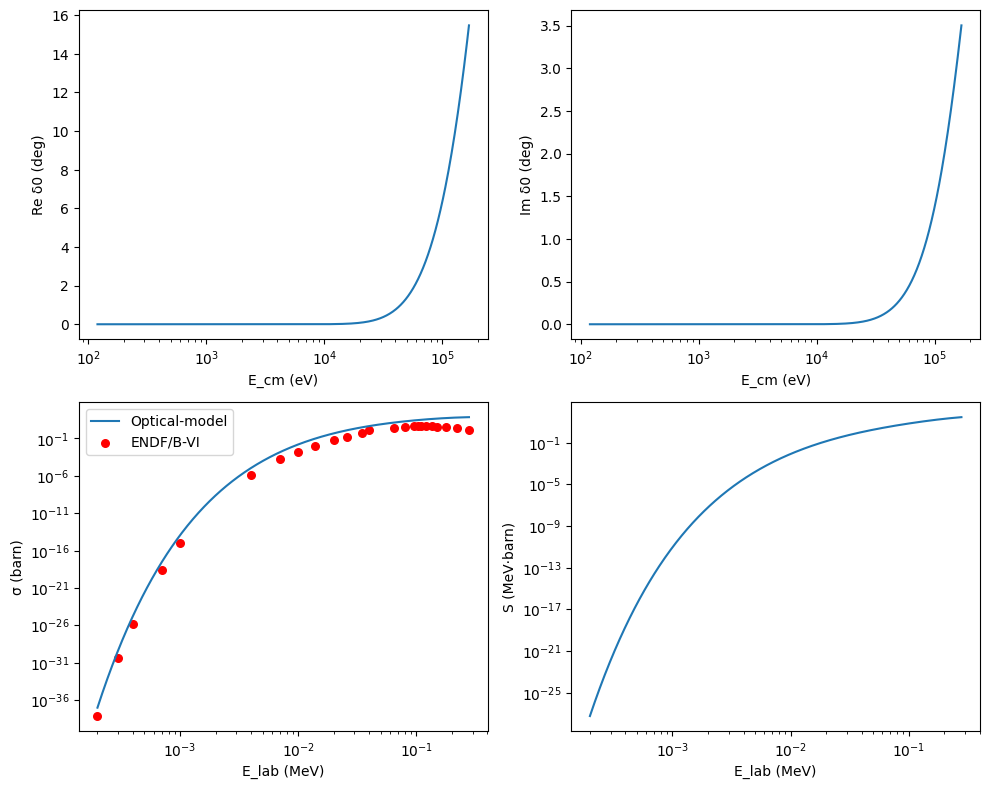

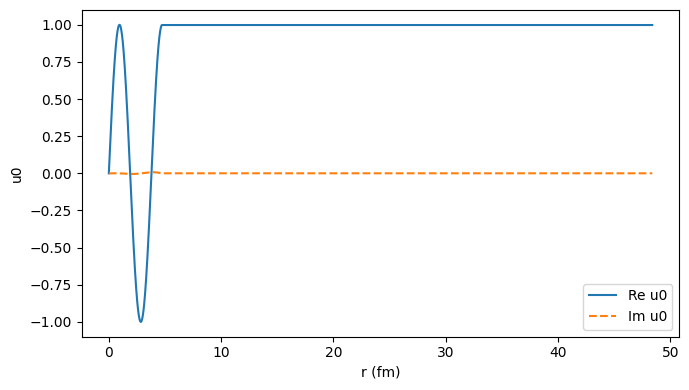

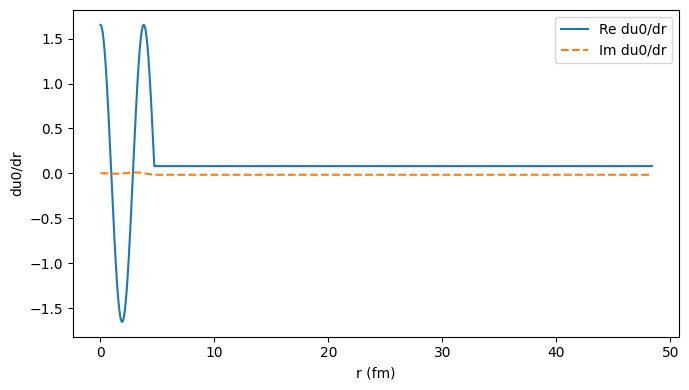

In [3]:
run_optical_model(
    Zp=1, Zt=1,        # deuterón + algo
    Ap=2, At=3,        # masas (amu)
    Vr=-47.667, Vi=-0.117292,   # potencial MeV
    r0=1.746,            # fm
    E_demo_cm_eV=500     # opcional: u0(r) a 50 keV
)

In [4]:

Ecm = (280000)/((2 + 3)/3)
print(Ecm)

168000.0


In [11]:
#media onda 
V_i = 16.8 #V_pp
V_o = 5.1 #V_pp
V_rms = V_o*2/np.pi
print(V_rms)

3.246760839074665


In [ ]:
#media onda 
V_i = 16.8 #V_pp
V_o = 5.1 #V_pp
V_rms = V_o*2/np.pi
print(V_rms)

In [12]:
#onda completa dos diodos 
V_i = 17.6 #V_pp
V_o = 8.2 #V_pp
#V_rms = V_o*2/np.pi
print(V_rms)

3.246760839074665


In [13]:
#onda completa dos diodos 
V_i = 34.4 #V_pp
V_o = 16.8 #V_pp
#V_rms = V_o*2/np.pi
print(V_rms)

3.246760839074665


In [ ]:
#onda completa 4  diodos 
V_i = 14.2 #V_pp
V_o = 8.2 #V_pp
#V_rms = V_o*2/np.pi
print(V_rms)